In [1]:
from tqdm import tqdm
import pickle
import pandas as pd
import numpy as np
import torch
import requests
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
import plotly.express as px
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel
import random
from scipy.spatial.distance import jensenshannon
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
import scipy.stats as st
from math import log2

In [2]:
PICKLES_ADDRESS =  '../data/pickles/'
SBIR_ADDRESS = '../data/sbir_dataset/'
PARALLEL_ADDRESS = 'data/parallel/'
TEMP_ADDRESS = 'temp/'

In [3]:
import psutil

def available_memory():
    available_ram = psutil.virtual_memory().available
    print(f"Available RAM: {available_ram / 1024 ** 3:.2f} GB")

def gpu_info():
    device = torch.device('cuda:0')
    torch.cuda.set_device(device)
    print('GPUs available:', torch.cuda.device_count())
    print('current GPU number: ', torch.cuda.current_device())
    print('GPU name: ', torch.cuda.get_device_name(device))
    print('GPU capability: ', torch.cuda.get_device_capability(device))
    print('GPU memory: ', torch.cuda.get_device_properties(device).total_memory)
    print('GPU memory allocated: ', torch.cuda.memory_allocated(device))
    print('GPU memory cached: ', torch.cuda.memory_reserved(device))
    print('GPU memory reserved: ', torch.cuda.memory_reserved(device))
    print('GPU memory free: ', torch.cuda.memory_reserved(device) - torch.cuda.memory_allocated(device))


def ram_info():
    !free -h


available_memory()
gpu_info()  
ram_info()

Available RAM: 477.48 GB
GPUs available: 3
current GPU number:  0
GPU name:  NVIDIA RTX 6000 Ada Generation
GPU capability:  (8, 9)
GPU memory:  51010207744
GPU memory allocated:  0
GPU memory cached:  0
GPU memory reserved:  0
GPU memory free:  0
               total        used        free      shared  buff/cache   available
Mem:           503Gi        21Gi       477Gi       108Mi       3.7Gi       477Gi
Swap:          3.0Ti        36Gi       3.0Ti


In [4]:
years = [str(year) for year in range(2010, 2022)]
correlation_lags = [-11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7, 8, 9, 10, 11]
print('years:', years)

years: ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']


In [5]:
with open(PICKLES_ADDRESS + 'dui2children.pkl', 'rb') as handle:
    dui2children = pickle.load(handle)
    print('dui2children:', len(dui2children))
with open(PICKLES_ADDRESS + 'dui2trail_final.pkl', 'rb') as handle:
    dui2parents = pickle.load(handle)
    print('dui2parents:', len(dui2parents))
with open(PICKLES_ADDRESS + 'heading2dui_final.pkl', 'rb') as handle:
    dui2name = pickle.load(handle)
    print('dui2name:', len(dui2name))
with open(PICKLES_ADDRESS + 'dui2header_final.pkl', 'rb') as handle:
    name2dui = pickle.load(handle)
    print('name2dui:', len(name2dui))
with open(PICKLES_ADDRESS + 'dui2level_final.pkl', 'rb') as handle:
    dui2level = pickle.load(handle)
    print('dui2level:', len(dui2level))
with open(PICKLES_ADDRESS + 'level2duis_final.pkl', 'rb') as handle:
    level2duis = pickle.load(handle)
    print('level2duis:', len(level2duis))
with open(PICKLES_ADDRESS + 'dui2trail.pkl', 'rb') as handle:
    dui2trail = pickle.load(handle)
    print('dui2trail:', len(dui2trail))
with open(PICKLES_ADDRESS + 'dui_intersection_final.pkl', 'rb') as handle:
    dui_intersections = pickle.load(handle)
    print('dui_intersections:', len(dui_intersections))
with open(PICKLES_ADDRESS + 'excluded_duis_final.pkl', 'rb') as handle:
    excluded_duis = pickle.load(handle)
    print('excluded_duis:', len(excluded_duis))
with open(PICKLES_ADDRESS + 'dui2pubfreq.pkl', 'rb') as handle:
    dui2pubfreq = pickle.load(handle)
    print('dui2pubfreq:', len(dui2pubfreq))
with open(PICKLES_ADDRESS + 'dui2sbfreq.pkl', 'rb') as handle:
    dui2sbfreq = pickle.load(handle)
    print('dui2sbfreq:', len(dui2sbfreq))
with open(PICKLES_ADDRESS + 'dui2pubfreqchild.pkl', 'rb') as handle:
    dui2pubfreqchild = pickle.load(handle)
    print('dui2pubfreqchild:', len(dui2pubfreqchild))
with open(PICKLES_ADDRESS + 'dui2sbfreqchild.pkl', 'rb') as handle:
    dui2sbfreqchild = pickle.load(handle)
    print('dui2sbfreqchild:', len(dui2sbfreqchild))
with open(TEMP_ADDRESS + 'dui2pubcit.pkl', 'rb') as handle:
    dui2pubcit = pickle.load(handle)
    print('dui2pubcit:', len(dui2pubcit))
with open(TEMP_ADDRESS + 'dui2sbcit.pkl', 'rb') as handle:
    dui2sbcit = pickle.load(handle)
    print('dui2sbcit:', len(dui2sbcit))
with open(TEMP_ADDRESS + 'dui2pubcitchild.pkl', 'rb') as handle:
    dui2pubcitchild = pickle.load(handle)
    print('dui2pubcitchild:', len(dui2pubcitchild))
with open(TEMP_ADDRESS + 'dui2sbcitchild.pkl', 'rb') as handle:
    dui2sbcitchild = pickle.load(handle)
    print('dui2sbcitchild:', len(dui2sbcitchild))

dui2children: 29432
dui2parents: 29307
dui2name: 29307
name2dui: 29307
dui2level: 29307
level2duis: 14
dui2trail: 29432
dui_intersections: 29307
excluded_duis: 723
dui2pubfreq: 29307
dui2sbfreq: 29307
dui2pubfreqchild: 29307
dui2sbfreqchild: 29307
dui2pubcit: 29307
dui2sbcit: 29307
dui2pubcitchild: 29307
dui2sbcitchild: 29307


In [6]:
#read 'data/pubmed_dataset/pmid2emb2d.pkl'
with open(PICKLES_ADDRESS + 'pmid2emb2d.pkl', 'rb') as handle:
    pmid2emb2d = pickle.load(handle)
    print('pmid2emb2d:', len(pmid2emb2d))

#read 'data/pubmed_dataset/sbid2emb2d.pkl'
with open(PICKLES_ADDRESS + 'sbid2emb2d.pkl', 'rb') as handle:
    sbid2emb2d = pickle.load(handle)    
    print('sbid2emb2d:', len(sbid2emb2d))

pmid2emb2d: 10928078
sbid2emb2d: 63488


In [7]:
# store all duis that have no frequency at any year of the dui2pubfreq dictionary and store them in a list called exduis
exduis = {}
for dui in dui2sbfreq:
    c = 0
    for year in years:
        c += len(dui2sbfreq[dui][year])
    if c == 0:
        exduis[dui] = True
    else:
        exduis[dui] = False

# count how many excuis have False and True values
c = 0
for dui in exduis:
    if exduis[dui] == False:
        c += 1
print(c, 'DUIs remained.')

10873 DUIs remained.


In [8]:
def calculate_jsd(p, q):
    m = 0.5 * (p + q)
    jsd = 0.5 * st.entropy(p, m) + 0.5 * st.entropy(q, m)
    return jsd

In [9]:
all_pubmed_embs = np.array([list(each) for each in list(pmid2emb2d.values())])
all_sbir_embs = np.array([list(each) for each in list(sbid2emb2d.values())])
all_pubmed_embs.shape, all_sbir_embs.shape

((10928078, 2), (63488, 2))

In [10]:
all_pubmed_embs[0]

array([ 1.75062227, -2.57721747])

In [11]:
all_embeddings = np.concatenate((all_pubmed_embs, all_sbir_embs))
all_embeddings.shape

(10991566, 2)

In [12]:
min_general = np.min(all_embeddings, axis=0)
max_general = np.max(all_embeddings, axis=0)
min_general, max_general

(array([-5.57435514, -4.74475388]), array([5.91685115, 5.87501581]))

Raw TVD: 0.8227752639517345
Raw JSD: 0.4599998765680119
Raw HLD: 0.7760362784115266
KDE TVD: 0.45260198108481564
KDE JSD: 0.16215192648589455
KDE HLD: 0.4330415515168357


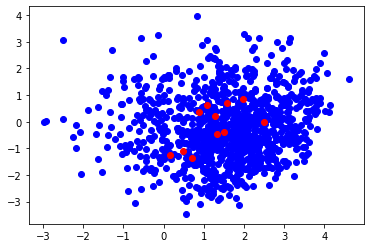

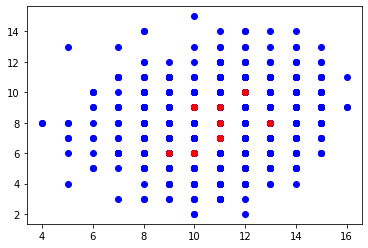

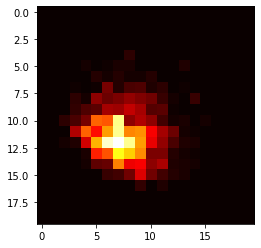

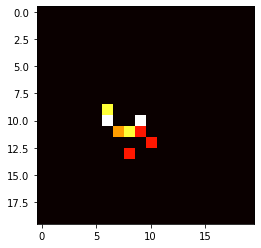

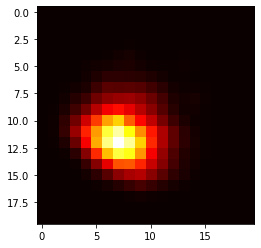

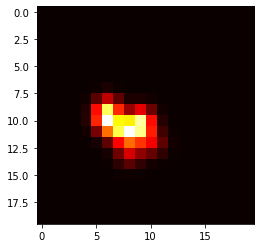

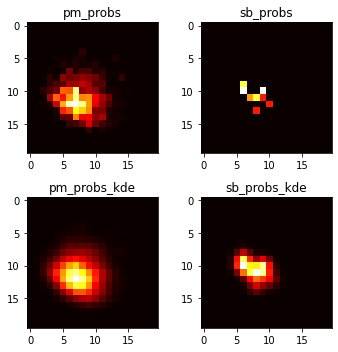

In [13]:
dui2mat = {k: np.ones((len(years), len(years))) for k in list(dui2sbfreqchild.keys())}
bin_sizes = np.array([20, 20]) #each dim will be discretized into 20 bins
kde_samples = np.array([[i, j] for i in range(bin_sizes[0]) for j in range(bin_sizes[1])])

gimi = False
for dui in list(dui2sbfreqchild.keys()):
    if not exduis[dui]:    
        for pm_year_idx, pm_year in enumerate(years):
            for sb_year_idx, sb_year in enumerate(years):
                pmids = dui2pubfreqchild[dui][pm_year]
                sbids = dui2sbfreqchild[dui][sb_year]

                if len(pmids) == 0 or len(sbids) == 0:
                    continue

                if len(pmids) < 10 or len(sbids) < 10:
                    continue

                #embed each pmid and sbid from pmids and sbids in a 2d space using the pmid2emb2d and sbid2emb2d dictionaries
                pm_embs = np.array([pmid2emb2d[pmid] for pmid in pmids])
                sb_embs = np.array([sbid2emb2d[sbid] for sbid in sbids])

                pm_impacts = dui2pubcitchild[dui][pm_year]
                sb_impacts = dui2sbcitchild[dui][sb_year]

                # Discretize embeddings
                pm_embs_disc = np.floor((pm_embs - min_general) / (max_general - min_general) * (bin_sizes - 1)).astype(int)
                sb_embs_disc = np.floor((sb_embs - min_general) / (max_general - min_general) * (bin_sizes - 1)).astype(int)

                pm_bin_impact = np.zeros((bin_sizes[0], bin_sizes[1]))
                sb_bin_impact = np.zeros((bin_sizes[0], bin_sizes[1]))

                # print('pm_embs:', pm_embs.shape)
                # print('sb_embs:', sb_embs.shape)
                # print('pm_impacts:', len(pm_impacts))
                # print('sb_impacts:', len(sb_impacts))
                # print('pm_embs_disc:', pm_embs_disc.shape)
                # print('sb_embs_disc:', sb_embs_disc.shape)
                # print('pm_bin_impact:', pm_bin_impact.shape)
                # print('sb_bin_impact:', sb_bin_impact.shape)
                # print(np.max(pm_embs_disc, axis=0))

                # Accumulate the impact scores for each bin for pubmeed
                for i in range(len(pm_embs_disc)):
                    x, y = pm_embs_disc[i]
                    pm_bin_impact[x, y] += pm_impacts[i]

                # Accumulate the impact scores for each bin for sbirs
                for i in range(len(sb_embs_disc)):
                    x, y = sb_embs_disc[i]
                    sb_bin_impact[x, y] += sb_impacts[i]

                pm_probs = pm_bin_impact / np.sum(pm_bin_impact)
                pm_probs = pm_probs.flatten()
                sb_probs = sb_bin_impact / np.sum(sb_bin_impact)
                sb_probs = sb_probs.flatten()

                # define grids for kde
                x_grid, y_grid = np.mgrid[0:bin_sizes[0]:bin_sizes[0]*1j, 0:bin_sizes[1]:bin_sizes[1]*1j]
                xy_grid = np.vstack([x_grid.ravel(), y_grid.ravel()])

                # apply kde to probabilties
                regularization_factor = 0.8
                pmkde = KernelDensity(bandwidth=regularization_factor).fit(pm_embs_disc, sample_weight=pm_impacts)
                pm_probs_kde = np.exp(pmkde.score_samples(kde_samples)).reshape(bin_sizes)
                pm_probs_kde = pm_probs_kde.flatten()

                # Perform kernel density estimation on sb_embs_disc using sb_impacts
                sbkde = KernelDensity(bandwidth=regularization_factor).fit(sb_embs_disc, sample_weight=sb_impacts)
                sb_probs_kde = np.exp(sbkde.score_samples(kde_samples)).reshape(bin_sizes)
                sb_probs_kde = sb_probs_kde.flatten()

                # calculate TVD and JSD on raw probabilities
                tvd = 0.5 * np.sum(np.abs(pm_probs - sb_probs))
                jsd = calculate_jsd(pm_probs, sb_probs)
                hld = np.sqrt(0.5 * np.sum((np.sqrt(pm_probs) - np.sqrt(sb_probs)) ** 2))
                print('Raw TVD:', tvd)
                print('Raw JSD:', jsd)
                print('Raw HLD:', hld)

                # calculate TVD and JSD on kde probabilities
                tvd = 0.5 * np.sum(np.abs(pm_probs_kde - sb_probs_kde))
                jsd = calculate_jsd(pm_probs_kde, sb_probs_kde)
                hld = np.sqrt(0.5 * np.sum((np.sqrt(pm_probs_kde) - np.sqrt(sb_probs_kde)) ** 2))
                print('KDE TVD:', tvd)
                print('KDE JSD:', jsd)
                print('KDE HLD:', hld)

                #plot the original pmids and sbids in the 2d spac
                plt.scatter(*zip(*pm_embs), color='blue')
                plt.scatter(*zip(*sb_embs), color='red') 
                plt.show()

                #plot the discretized pmids and sbids in the 2d space
                plt.scatter(*zip(*pm_embs_disc), color='blue')
                plt.scatter(*zip(*sb_embs_disc), color='red')
                plt.show()

                #plot the matrices where cells with higher values are more red
                plt.imshow(pm_probs.reshape(bin_sizes), cmap='hot', interpolation='nearest')
                plt.show()
                plt.imshow(sb_probs.reshape(bin_sizes), cmap='hot', interpolation='nearest')
                plt.show()

                #plot the kde matrices where cells with higher values are more red
                plt.imshow(pm_probs_kde.reshape(bin_sizes), cmap='hot', interpolation='nearest')
                plt.show()
                plt.imshow(sb_probs_kde.reshape(bin_sizes), cmap='hot', interpolation='nearest')
                plt.show()

                #now plot all 4 matrices in a 2x2 grid, set the titles to pm_prob, sb_prob, pm_prob_kde, sb_prob_kde
                fig, axs = plt.subplots(2, 2, figsize=(5, 5))  # Adjust the figsize according to your preference
                axs[0, 0].imshow(pm_probs.reshape(bin_sizes), cmap='hot', interpolation='nearest')
                axs[0, 0].set_title('pm_probs')
                axs[0, 1].imshow(sb_probs.reshape(bin_sizes), cmap='hot', interpolation='nearest')
                axs[0, 1].set_title('sb_probs')
                axs[1, 0].imshow(pm_probs_kde.reshape(bin_sizes), cmap='hot', interpolation='nearest')
                axs[1, 0].set_title('pm_probs_kde')
                axs[1, 1].imshow(sb_probs_kde.reshape(bin_sizes), cmap='hot', interpolation='nearest')
                axs[1, 1].set_title('sb_probs_kde')
                plt.tight_layout()  # Ensures proper spacing between subplots
                plt.show()

                gimi = True
                if gimi:
                    break
            if gimi:
                break
        if gimi:
            break

In [14]:
np.max(pm_probs_kde)

0.03589433379505626

In [15]:
pmkde = KernelDensity(bandwidth=regularization_factor).fit(pm_embs_disc, sample_weight=pm_impacts)
samples = np.array([[i, j] for i in range(bin_sizes[0]) for j in range(bin_sizes[1])])
pm_probs_kde = np.exp(pmkde.score_samples(samples)).reshape(bin_sizes)
pm_probs_kde.shape

(20, 20)

In [16]:
min_general = np.min(all_embeddings, axis=0)
max_general = np.max(all_embeddings, axis=0)
min_general, max_general

(array([-5.57435514, -4.74475388]), array([5.91685115, 5.87501581]))

In [17]:
with open(PICKLES_ADDRESS + 'dui2trail_final.pkl', 'rb') as handle:
    dui2parents = pickle.load(handle)
    print('dui2parents:', len(dui2parents))

dui2parents: 29307


In [2]:
import os

already_processed = []
for filename in os.listdir(TEMP_ADDRESS + 'parallel/TVDs/'):
    already_processed.append(filename.split('_')[0])
already_processed = list(set(already_processed))
len(already_processed)

10039

In [20]:
from sklearn.neighbors import KernelDensity
from multiprocessing import Pool
from tqdm import tqdm

def process_dui(dui):
    parent = dui2parents[dui][0]
    if not exduis[dui] and dui not in already_processed and parent != 'U000008' and parent != 'U000011':
        for pm_year_idx, pm_year in enumerate(years):
            for sb_year_idx, sb_year in enumerate(years):
                pmids = dui2pubfreqchild[dui][pm_year]
                sbids = dui2sbfreqchild[dui][sb_year]         
    
                if len(pmids) == 0 or len(sbids) == 0:
                    continue           

                #embed each pmid and sbid from pmids and sbids in a 2d space using the pmid2emb2d and sbid2emb2d dictionaries
                pm_embs = np.array([pmid2emb2d[pmid] for pmid in pmids])
                sb_embs = np.array([sbid2emb2d[sbid] for sbid in sbids])
                pm_impacts = dui2pubcitchild[dui][pm_year]
                sb_impacts = dui2sbcitchild[dui][sb_year]
                pm_embs_disc = np.floor((pm_embs - min_general) / (max_general - min_general) * (bin_sizes - 1)).astype(int)
                sb_embs_disc = np.floor((sb_embs - min_general) / (max_general - min_general) * (bin_sizes - 1)).astype(int)
                pm_bin_impact = np.zeros((bin_sizes[0], bin_sizes[1]))
                sb_bin_impact = np.zeros((bin_sizes[0], bin_sizes[1]))
                for i in range(len(pm_embs_disc)):
                    x, y = pm_embs_disc[i]
                    pm_bin_impact[x, y] += pm_impacts[i]
                for i in range(len(sb_embs_disc)):
                    x, y = sb_embs_disc[i]
                    sb_bin_impact[x, y] += sb_impacts[i]

                pm_probs = pm_bin_impact / np.sum(pm_bin_impact) + 1e-10
                pm_probs = pm_probs.flatten()
                sb_probs = sb_bin_impact / np.sum(sb_bin_impact) + 1e-10
                sb_probs = sb_probs.flatten()

                regularization_factor = 0.8
                pmkde = KernelDensity(bandwidth=regularization_factor).fit(pm_embs_disc, sample_weight=pm_impacts)
                pm_probs_kde = np.exp(pmkde.score_samples(kde_samples)).reshape(bin_sizes)
                pm_probs_kde = pm_probs_kde.flatten()

                sbkde = KernelDensity(bandwidth=regularization_factor).fit(sb_embs_disc, sample_weight=sb_impacts)
                sb_probs_kde = np.exp(sbkde.score_samples(kde_samples)).reshape(bin_sizes)
                sb_probs_kde = sb_probs_kde.flatten()

                tvd = 0.5 * np.sum(np.abs(pm_probs_kde - sb_probs_kde))
                jsd = calculate_jsd(pm_probs_kde, sb_probs_kde)
                hld = np.sqrt(0.5 * np.sum((np.sqrt(pm_probs_kde) - np.sqrt(sb_probs_kde)) ** 2))

                # save tvd jsd and hld as txt files that contain the scores for the dui. name the files as <dui>_<pm_year>_<sb_year>_TVD.txt, <dui>_<pm_year>_<sb_year>_JSD.txt, <dui>_<pm_year>_<sb_year>_HLD.txt in folder data/parallel/TVDs, data/parallel/JSDs, data/parallel/HLDs
                with open(TEMP_ADDRESS + 'parallel/TVDs/' + dui + '_' + str(pm_year) + '_' + str(sb_year) + '_TVD.txt', 'w') as f:
                    f.write(str(tvd))
                with open(TEMP_ADDRESS + 'parallel/JSDs/' + dui + '_' + str(pm_year) + '_' + str(sb_year) + '_JSD.txt', 'w') as f:
                    f.write(str(jsd))
                with open(TEMP_ADDRESS + 'parallel/HLDs/' + dui + '_' + str(pm_year) + '_' + str(sb_year) + '_HLD.txt', 'w') as f:
                    f.write(str(hld))

                fig, axs = plt.subplots(2, 2, figsize=(5, 5))  # Adjust the figsize according to your preference
                axs[0, 0].imshow(pm_probs.reshape(bin_sizes), cmap='hot', interpolation='nearest')
                axs[0, 0].set_title('pm_probs')
                axs[0, 1].imshow(sb_probs.reshape(bin_sizes), cmap='hot', interpolation='nearest')
                axs[0, 1].set_title('sb_probs')
                axs[1, 0].imshow(pm_probs_kde.reshape(bin_sizes), cmap='hot', interpolation='nearest')
                axs[1, 0].set_title('pm_probs_kde')
                axs[1, 1].imshow(sb_probs_kde.reshape(bin_sizes), cmap='hot', interpolation='nearest')
                axs[1, 1].set_title('sb_probs_kde')
                plt.tight_layout()  # Ensures proper spacing between subplots
                plt.savefig(TEMP_ADDRESS + 'parallel/plots/{}_{}_{}.png'.format(dui, pm_year, sb_year))
                plt.close()

                del pm_embs, sb_embs, pm_impacts, sb_impacts, pm_embs_disc, sb_embs_disc, pm_bin_impact, sb_bin_impact, pm_probs, sb_probs, pm_probs_kde, sb_probs_kde


# Modify the outer loop to create a list of 'duis'
duis = list(dui2sbfreqchild.keys())

# Define the number of processes to match the number of CPU cores
num_processes = 120

# Create a progress bar using tqdm
with tqdm(total=len(duis)) as pbar:
    # Create a pool of processes
    with Pool(processes=num_processes) as pool:
        # Map 'process_dui' to 'duis' using pool.map
        for _ in pool.imap_unordered(process_dui, duis):
            pbar.update(1)  # Update the progress bar

100%|██████████| 29307/29307 [01:02<00:00, 472.49it/s] 


In [33]:
a = [k for k, v in exduis.items() if not v]
b = already_processed
#find what elements are in a but not in b
c = [item for item in a if item not in b]
print(c)

['D016240']
